In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import rcParams
from matplotlib.cm import rainbow
import warnings
warnings.filterwarnings('ignore')
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [3]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [4]:
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [5]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_cardio_train', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- age_yrs: integer (nullable = true)
 |-- weight_lbs: double (nullable = true)
 |-- height_inches: double (nullable = true)
 |-- bmi: double (nullable = true)

+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-------+------------------+-------------+------------------+
|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_yrs|        weight_lbs|height_inches|               bmi|
+-----+-----+------+------+------+---

In [6]:
#convert to pandas df
heart_cardio = entireDF.select("*").toPandas()
heart_cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,84851,23386,2,162,84.0,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,84852,19540,1,164,83.0,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,84853,20192,1,158,77.0,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,84854,15406,1,163,61.0,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,84857,17632,1,152,80.0,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


In [7]:
heart_cardio=heart_cardio.drop(columns=['id','age', 'height','weight'], axis=1)
heart_cardio.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,2,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,1,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,1,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,1,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,1,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


In [13]:
#Rename columns
heart_cardio=heart_cardio.rename(columns={"ap_hi": "systolic pressure", "ap_lo": "diastolic pressure", "alco": "alcohol"})
heart_cardio.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,smoke,alcohol,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,2,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,1,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,1,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,1,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,1,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


# Data-preprocessing

In [9]:
heart_cardio.describe()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
count,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000,68662.000000
mean,1.348766,126.618901,81.368734,1.364874,1.226006,0.088055,0.053625,0.803458,0.494903,52.829207,163.414123,64.739279,45.053371
std,0.476583,16.752806,9.590851,0.679089,0.571975,0.283376,0.225278,0.397386,0.499978,6.768510,31.502418,3.092243,8.324257
min,1.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,77.161700,48.031522,20.710059
25%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,143.300300,62.598459,39.393939
50%,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,158.732640,64.960665,43.589744
75%,2.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,180.778840,66.929170,49.421125
max,2.000000,240.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,440.924000,81.496107,133.600000


In [63]:
# # import seaborn as sns
# sns.pairplot(data=heart_cardio)

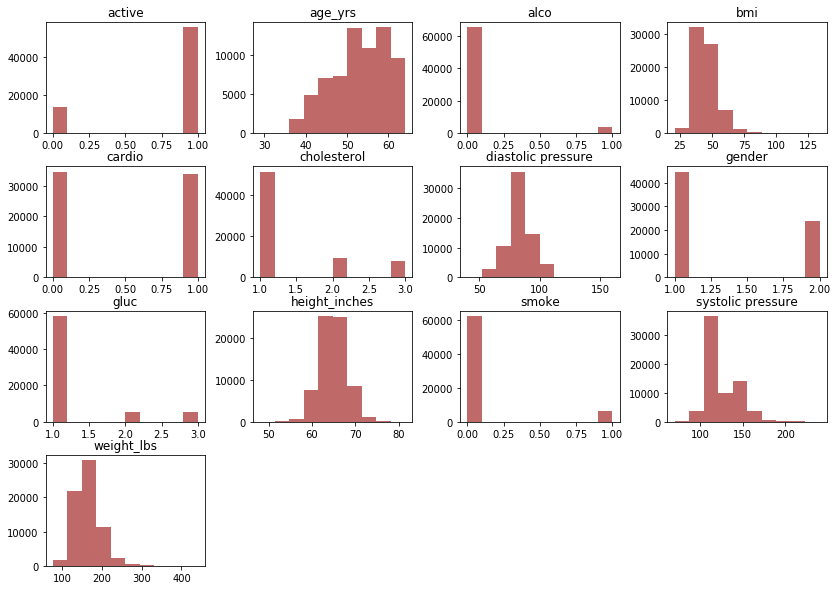

In [10]:
heart_cardio.hist(figsize=(14,10), color="brown",alpha=0.7, grid=False);

In [43]:
# 'age_yrs', 'bmi', 'height_inches', 'weight_lbs', 'systolic pressure', 'diastolic pressure'


In [65]:
#Check count
a,b=np.bincount(heart_cardio.cardio)
print(f"Percentage of data distribution in the two classes are:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))

Percentage of data distribution in the two classes are:
50.51
49.49


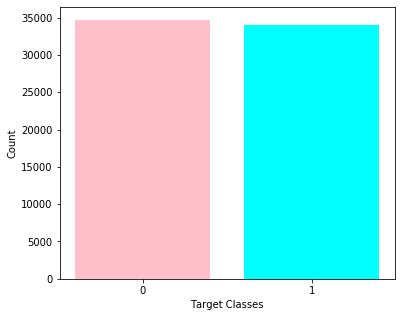

In [66]:
#Visualize
rcParams['figure.figsize'] = 6,5
plt.bar(heart_cardio['cardio'].unique(), heart_cardio['cardio'].value_counts(), color = ['pink','cyan'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count');

# Data Pre-Processing
From EDA, it is clear that the data needs to be scaled before proceeding and categorical variables need to be converted to dummy variables.

### Feature Selection
#### 1.Univariate Selection:
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features. The code below uses the chi-squared (chi²) statistical test to select 10 of the best features. 

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = heart_cardio.drop("cardio", axis=1) 
y = heart_cardio["cardio"]   
# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
# X.head()
# y.head()

                 Specs         Score
1    systolic pressure  27530.500731
9           weight_lbs  13524.046201
2   diastolic pressure   8811.089158
11                 bmi   3898.296469
8              age_yrs   3411.342895
3          cholesterol   1137.980787
4                 gluc    148.227152
7               active     18.808573
5                smoke     16.555609
6              alcohol      4.343950


#### 2. Feature importance:
Feature importance is an inbuilt class that comes with Tree Based Classifiers. Extra Tree Classifier is used for extracting the top 10 features for the dataset.

[0.01159916 0.18529733 0.09546904 0.04441234 0.01489997 0.00662567
 0.00617253 0.00801474 0.16093439 0.14114058 0.15113533 0.17429892]


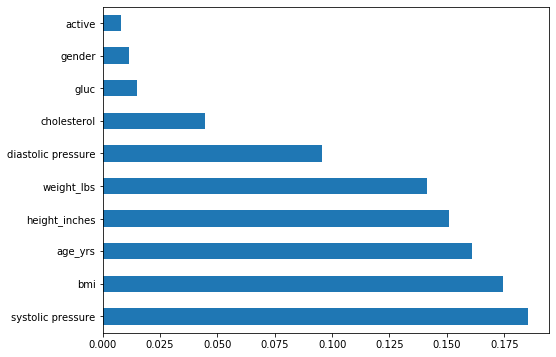

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 8,6
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### 3.Correlation Matrix with Heatmap
Correlation heatmap is built using the seaborn library to identify which features are most related to each other or the target variable. 

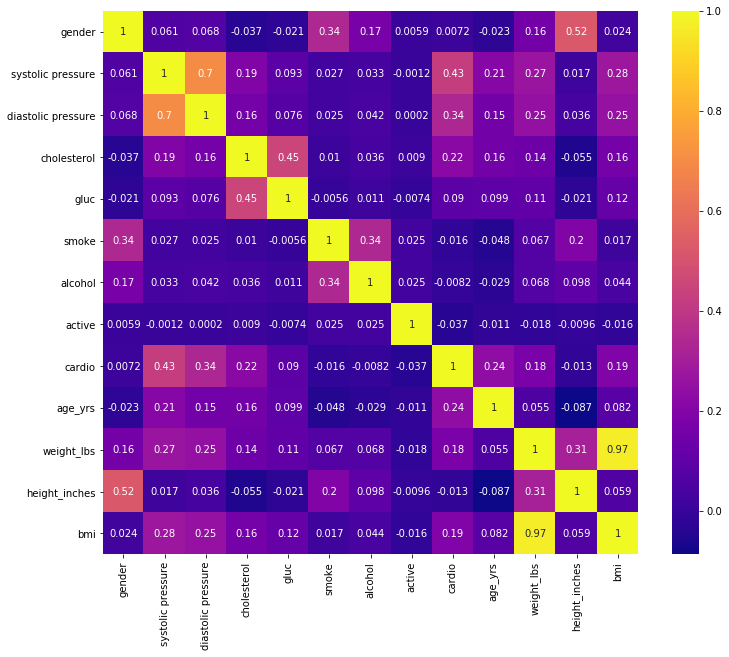

In [25]:
#get correlations of each features in dataset
import seaborn as sns
corrmat = heart_cardio.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,10))
#plot heat map
g=sns.heatmap(heart_cardio[top_corr_features].corr(),annot=True,cmap="plasma")

From analysis of the above three processes for feature selection, and distribution of data in categorical features as seen in the histograms above, the following features have been selected based on the feature name appearing in atleast two of the three selection tests above:
systolic pressure,diastolic pressure, bmi, age_yrs, weight_lbs, chol, glu, gender, active. 
While smoke and alcohol are known to be great risk factors, but their distribution in the classes is highly imbalanced to train the model. Also, they show negative correlation with the target in the heatmap and don't appear in the feature importance plot.Active is selcted despite showing negative correlation as it appears in the other two selection processes.

In [39]:
#Drop rest of the features and create new df
feature_selected_df = heart_cardio.drop(['smoke', 'alcohol','height_inches'], axis=1)
feature_selected_df.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,active,cardio,age_yrs,weight_lbs,bmi
0,2,160,90,1,1,1,0,64,185.18808,51.851852
1,1,120,80,1,1,1,0,53,182.98346,50.609756
2,1,100,70,1,1,1,0,55,169.75574,48.734177
3,1,140,90,1,1,1,1,42,134.48182,37.423313
4,1,140,90,2,1,1,1,48,176.36960,52.631579


### Dummy encoding categorical features

In [40]:
#Processing categorical features
dataset = pd.get_dummies(feature_selected_df, columns = ['active','cholesterol','gender','gluc'])
dataset.head()

,systolic pressure,diastolic pressure,cardio,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,160,90,0,64,185.18808,51.851852,0,1,1,0,0,0,1,1,0,0
1,120,80,0,53,182.98346,50.609756,0,1,1,0,0,1,0,1,0,0
2,100,70,0,55,169.75574,48.734177,0,1,1,0,0,1,0,1,0,0
3,140,90,1,42,134.48182,37.423313,0,1,1,0,0,1,0,1,0,0
4,140,90,1,48,176.36960,52.631579,0,1,0,1,0,1,0,1,0,0


### Data Scaling

In [43]:
#Scaling continuous features using StandardScaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
columns_to_scale = ['age_yrs', 'bmi', 'weight_lbs', 'systolic pressure', 'diastolic pressure']
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
dataset.head()

,systolic pressure,diastolic pressure,cardio,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,1.992582,0.899954,0,1.650418,0.691189,0.816713,0,1,1,0,0,0,1,1,0,0
1,-0.395095,-0.142713,0,0.025234,0.621206,0.667498,0,1,1,0,0,1,0,1,0,0
2,-1.588934,-1.185381,0,0.320722,0.201307,0.442182,0,1,1,0,0,1,0,1,0,0
3,0.798744,0.899954,1,-1.599951,-0.918422,-0.916612,0,1,1,0,0,1,0,1,0,0
4,0.798744,0.899954,1,-0.713487,0.411256,0.910383,0,1,0,1,0,1,0,1,0,0


In [41]:
#Scaling continuous features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
columns_to_scale = ['age_yrs', 'bmi', 'weight_lbs', 'systolic pressure', 'diastolic pressure']
dataset[columns_to_scale]=minmaxscaler.fit_transform(columns_to_scale)
dataset.head()

ValueError: could not convert string to float: 'age_yrs'

In [31]:
target = dataset["cardio"]
data = dataset.drop("cardio", axis=1)
feature_names = data.columns
data.head()

,systolic pressure,diastolic pressure,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,1.992582,0.899954,1.650418,0.691189,0.816713,0,1,1,0,0,0,1,1,0,0
1,-0.395095,-0.142713,0.025234,0.621206,0.667498,0,1,1,0,0,1,0,1,0,0
2,-1.588934,-1.185381,0.320722,0.201307,0.442182,0,1,1,0,0,1,0,1,0,0
3,0.798744,0.899954,-1.599951,-0.918422,-0.916612,0,1,1,0,0,1,0,1,0,0
4,0.798744,0.899954,-0.713487,0.411256,0.910383,0,1,0,1,0,1,0,1,0,0


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_train.info()
X_test.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51496 entries, 60797 to 15795
Data columns (total 15 columns):
systolic pressure     51496 non-null float64
diastolic pressure    51496 non-null float64
age_yrs               51496 non-null float64
weight_lbs            51496 non-null float64
bmi                   51496 non-null float64
active_0              51496 non-null uint8
active_1              51496 non-null uint8
cholesterol_1         51496 non-null uint8
cholesterol_2         51496 non-null uint8
cholesterol_3         51496 non-null uint8
gender_1              51496 non-null uint8
gender_2              51496 non-null uint8
gluc_1                51496 non-null uint8
gluc_2                51496 non-null uint8
gluc_3                51496 non-null uint8
dtypes: float64(5), uint8(10)
memory usage: 2.8 MB


systolic pressure     17166
diastolic pressure    17166
age_yrs               17166
weight_lbs            17166
bmi                   17166
active_0              17166
active_1              17166
cholesterol_1         17166
cholesterol_2         17166
cholesterol_3         17166
gender_1              17166
gender_2              17166
gluc_1                17166
gluc_2                17166
gluc_3                17166
dtype: int64

In [34]:
# Check if the labels are well shuffled in train and test set, to avoid imbalanced data
a,b=np.bincount(y_train)
print(f"Percentage of data distribution in the train set:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))
print("-------------------")
x,y=np.bincount(y_test)
print(f"Percentage of data distribution in the test set:")
print(round(x/(x+y)*100,2))
print(round(y/(x+y)*100,2))
# np.bincount(y_test)

Percentage of data distribution in the train set:
50.55
49.45
-------------------
Percentage of data distribution in the test set:
50.39
49.61


In [86]:
# from sklearn.preprocessing import StandardScaler as ss
# sc = ss()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)



## Applying Machine Learning Algorithms



In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Logistic Regression

In [37]:
lg = LogisticRegression()
# Create an instance of Logistic Regression Classifier and fit the data.
lg.fit(X_train,y_train)
lg_score=round(lg.score(X_train,y_train)*100,2)
lg_score

72.77

### K Neighbors Classifier
The classification parameters are values of neighbors (k) and distance. Different values of neighbours will be used to check the best output score.

In [38]:
#Hold the scores for various neighbors i.e. k in a list
knn_scores = []
for i in range(1,10):
    knn_classifier = KNeighborsClassifier(n_neighbors = i)
    knn_classifier.fit(X_train, y_train)
    knn_scores.append(round(knn_classifier.score(X_test, y_test)*100,2))
        
knn_scores

[63.81, 64.57, 68.08, 67.97, 69.17, 69.78, 70.62, 70.76, 71.29]

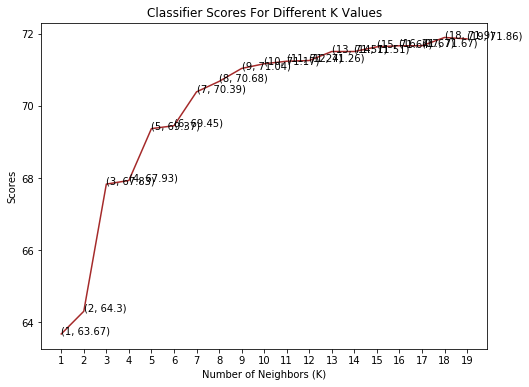

In [79]:
rcParams['figure.figsize'] = 8,6
plt.plot([i for i in range(1, 20)], knn_scores, color = 'brown' )
for i in range(1,20):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
#     plt.text(i, knn_scores[i-1])

plt.xticks([i for i in range(1, 20)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('Classifier Scores For Different K Values');

### Support Vector Classifier
First testing all kernels. Second, select the best kernel and perform Hyperparameter Tuning 

In [44]:
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    svc_classifier.fit(X_train, y_train)
    svc_scores.append(round(svc_classifier.score(X_test, y_test)*100,2))
svc_scores

[72.64, 73.09, 73.35, 61.03]

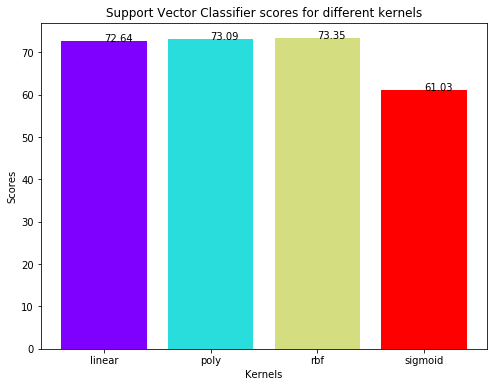

In [45]:
rcParams['figure.figsize'] = 8,6
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels');

In [ ]:
from sklearn.model_selection import GridSearchCV
model = SVC(kernel='rbf')
param_grid = {'C': [1, 5, 10, 30, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)
# Train the model with GridSearch
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=1, gamma=0.0001, score=0.725, total= 1.3min
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.715, total= 1.2min
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.721, total= 1.2min
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.721, total= 1.2min
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.727, total= 1.4min
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.728, total= 1.3min
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.715, total= 1.2min
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.727, total= 1.3min
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.725, total= 1.1min
[CV] C=1, gamma=0.0005 ...............................................
[CV] .

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# Training score:
grid.score(X_train, y_train)
# Testing score:
grid.score(X_test, y_test)

In [ ]:
# Print Classification Report.
# Make prediction and save to variable for report.
svc_predictions = grid.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, svc_predictions))

In [ ]:
DT_scores = []
# since max_features is len(X.columns its sqrt will return floatingpoint which has to be typcast to int using the code below
# int(np.ceil(np.sqrt(len(X.columns) + 1)))
for i in range(1, int(np.ceil(np.sqrt(len(X.columns))))+1):
    DT_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    DT_classifier.fit(X_train, y_train)
    DT_scores.append(round(DT_classifier.score(X_test, y_test)*100,2))
DT_scores

In [ ]:
print("The score for Decision Tree Classifier is {}% with {} maximum features.".format(DT_scores[5], 6))

In [ ]:
rf_scores = []
estimators = [10, 100, 200, 500, 700, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(X_train, y_train)
    rf_scores.append(round(rf_classifier.score(X_test, y_test)*100,2))

In [ ]:
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators');

In [ ]:
print("The score for Random Forest Classifier is {}% with {} estimators.".format(rf_scores[2], [200, 700,1000]))

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = NB_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = NB_classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Naive Bayes = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Naive Bayes = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

# Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import warnings
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [ ]:
NN_model = Sequential()
# model.add(Dense(11,activation='relu',input_dim=13))
# model.add(Dense(1,activation='sigmoid'))

# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
NN_model.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
NN_model.add(Dense(units=100, activation='relu'))
NN_model.add(Dense(units=9915, activation ="softmax"))

In [ ]:
NN_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

In [ ]:
NN_model.fit(X_train,y_train, epochs=100, verbose=2)

In [ ]:
NN_model_loss, NN_model_accuracy = NN_model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {NN_model_loss}, Accuracy: {round(NN_model_accuracy*100,2)}")